In [3]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

from datasets import load_dataset
import pandas as pd

/Users/monika/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
file_path = 'Datasets/udataset.xlsx'
#file_path = "new.xlsx"

In [7]:
df = pd.read_excel(file_path)
df.head()

,Substance,Substance_lower,CAS_number,SMILES,Additional info,Irritation,Source
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN


## Data loading

In [68]:

# Load dataset with a specified config
dataset_train = load_dataset("maomlab/AttentiveSkin", "Irrit_Neg", split="train")
dataset_test = load_dataset("maomlab/AttentiveSkin", "Irrit_Neg", split="test")
# Convert to Pandas DataFrame
df_train = pd.DataFrame(dataset_train)
df_test = pd.DataFrame(dataset_test)

#df = pd.concat([df_train, df_test], ignore_index=True)
df = df_test

# Display the first few rows
print(df.head())

                                                Name Synonym       CAS RN  Y  \
0  EU_CLP:\nN,N'-(2,2-dimethylpropylidene)hexamet...    None    1000-78-8  1   
1                EU_CLP:\nisobutyl 3,4-epoxybutyrate    None  100181-71-3  1   
2           EU_CLP:\n8,9,10-trinorborn-2-yl acrylate    None   10027-06-2  1   
3          EU_CLP:\nα-chlorotoluene; benzyl chloride    None     100-44-7  1   
4                          ChemSkin:\nBenzyl alcohol    None     100-51-6  0   

                                       Detailed Page  \
0  EU_CLP: https://echa.europa.eu/information-on-...   
1  EU_CLP: https://echa.europa.eu/information-on-...   
2  EU_CLP: https://echa.europa.eu/information-on-...   
3  EU_CLP: https://echa.europa.eu/information-on-...   
4    ChemSkin: https://doi.org/10.3390/toxics9110314   

                                      Evidence OECD TG 404 Data Source  \
0                                         None        None      EU_CLP   
1                                 

## Descriptor calculation

In [69]:
def calculate_descriptors(df):
    # List to hold descriptor data for each row
    descriptor_data = []
    
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Append a dictionary of None values for all descriptors if SMILES is invalid
            descriptor_data.append({desc[0]: None for desc in Descriptors.descList})
            continue
        
        descriptors = {}
        for descriptor, function in Descriptors.descList:
            try:
                descriptors[descriptor] = function(mol)
            except Exception:
                descriptors[descriptor] = None
        
        descriptor_data.append(descriptors)
    
    # Create a DataFrame for descriptor values with the same index as the original DataFrame
    descriptors_df = pd.DataFrame(descriptor_data, index=df.index)
    
    # Concatenate original DataFrame with descriptor DataFrame
    df = pd.concat([df, descriptors_df], axis=1)
    
    return df

In [70]:
df = calculate_descriptors(df)
#f_o = calculate_descriptors(df_o)

In [71]:
df.shape

(259, 224)

## Columns cleaning

In [72]:
columns_to_drop = ["Substance", "Substance_lower", "CAS_number", "SMILES", "Additional info", "Source"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)
df.head()

KeyError: "['Substance', 'Substance_lower', 'CAS_number', 'Additional info', 'Source'] not found in axis"

In [73]:
columns_to_drop = ["Name", "Synonym", "CAS RN", "Detailed Page", "Evidence", "OECD TG 404", "Data Source","Frequency","SMILES", "SMILES URL", "SMILES Source",   "Canonical SMILES", "Split"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)
df.head()

,Y,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,5.396896,5.396896,0.233391,0.233391,0.499926,12.615385,184.327,160.135,184.193949,...,0,0,0,0,0,0,0,0,4,0
1,1,10.895694,10.895694,0.137778,-0.137778,0.451833,21.909091,158.197,144.085,158.094294,...,0,0,0,0,0,0,0,0,0,0
2,1,10.903819,10.903819,0.203009,-0.256898,0.462370,38.166667,166.220,152.108,166.099380,...,0,0,0,0,0,0,0,0,0,0
3,1,5.526914,5.526914,0.611944,0.611944,0.507329,9.125000,126.586,119.530,126.023628,...,0,0,0,0,0,0,0,0,0,0
4,0,8.537593,8.537593,0.139722,0.139722,0.572344,9.125000,108.140,100.076,108.057515,...,0,0,0,0,0,0,0,0,0,0


In [74]:
df.rename(columns={"Y":"Irritation"}, inplace=True)

In [61]:
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,5.396896,5.396896,0.233391,0.233391,0.499926,12.615385,184.327,160.135,184.193949,...,0,0,0,0,0,0,0,0,4,0
1,1,10.895694,10.895694,0.137778,-0.137778,0.451833,21.909091,158.197,144.085,158.094294,...,0,0,0,0,0,0,0,0,0,0
2,1,10.903819,10.903819,0.203009,-0.256898,0.462370,38.166667,166.220,152.108,166.099380,...,0,0,0,0,0,0,0,0,0,0
3,1,5.526914,5.526914,0.611944,0.611944,0.507329,9.125000,126.586,119.530,126.023628,...,0,0,0,0,0,0,0,0,0,0
4,0,8.537593,8.537593,0.139722,0.139722,0.572344,9.125000,108.140,100.076,108.057515,...,0,0,0,0,0,0,0,0,0,0


In [38]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets (modify with actual file paths or DataFrames)
df_rabbit = df_o  # Your small dataset (Rabbit testing)
df_large = df  # The larger dataset (database samples)

# Ensure both datasets have the same columns
common_columns = list(set(df_rabbit.columns) & set(df_large.columns))  # Find shared columns
df_rabbit = df_rabbit[common_columns]
df_large = df_large[common_columns]

# Drop target column (assuming it's named 'irritation' or change accordingly)
target_column = 'irritation'
if target_column in df_rabbit.columns:
    common_columns.remove(target_column)
    
print(f"Comparing {len(common_columns)} shared columns (excluding target: {target_column})\n")

# Store significantly different columns
different_columns = []

# Set threshold for mean/std deviation difference
mean_diff_threshold = 0.3  # Adjust as needed
std_diff_threshold = 0.3

# Perform Kolmogorov-Smirnov (KS) test for distribution similarity
ks_threshold = 0.05  # p-value threshold for rejecting similarity (lower = more strict)

# Iterate through features
for col in common_columns:
    # Compute mean and std differences
    mean_diff = abs(df_rabbit[col].mean() - df_large[col].mean()) / df_large[col].std()
    std_diff = abs(df_rabbit[col].std() - df_large[col].std()) / df_large[col].std()
    
    # Perform KS test (checks if two distributions are significantly different)
    ks_stat, ks_pval = stats.ks_2samp(df_rabbit[col].dropna(), df_large[col].dropna())
    
    # If differences exceed thresholds, mark column as different
    if mean_diff > mean_diff_threshold or std_diff > std_diff_threshold or ks_pval < ks_threshold:
        different_columns.append((col, mean_diff, std_diff, ks_pval))

# Print results
if different_columns:
    print(f"⚠️ {len(different_columns)} columns are significantly different between datasets:\n")
    print("{:<20} {:<10} {:<10} {:<10}".format("Feature", "Mean Diff", "Std Diff", "KS p-value"))
    print("-" * 60)
    for col, mean_diff, std_diff, ks_pval in different_columns:
        print(f"{col:<20} {mean_diff:<10.3f} {std_diff:<10.3f} {ks_pval:<10.3f}")
else:
    print("✅ No significant distribution differences detected.")

# Plot distributions of the most different columns
num_plots = min(6, len(different_columns))  # Plot up to 6 features for visualization
if num_plots > 0:
    plt.figure(figsize=(12, 6))
    for i, (col, _, _, _) in enumerate(different_columns[:num_plots]):
        plt.subplot(2, 3, i + 1)
        sns.kdeplot(df_rabbit[col], label="Rabbit Data", shade=True, color="blue")
        sns.kdeplot(df_large[col], label="Large Dataset", shade=True, color="red")
        plt.title(f"Feature: {col}")
        plt.legend()
    plt.tight_layout()
    plt.show()


NameError: name 'df_o' is not defined

In [75]:
columns_to_drop = ["BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)

In [76]:
df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,5.396896,5.396896,0.233391,0.233391,0.499926,12.615385,184.327,160.135,184.193949,...,0,0,0,0,0,0,0,0,4,0
1,1,10.895694,10.895694,0.137778,-0.137778,0.451833,21.909091,158.197,144.085,158.094294,...,0,0,0,0,0,0,0,0,0,0
2,1,10.903819,10.903819,0.203009,-0.256898,0.462370,38.166667,166.220,152.108,166.099380,...,0,0,0,0,0,0,0,0,0,0
3,1,5.526914,5.526914,0.611944,0.611944,0.507329,9.125000,126.586,119.530,126.023628,...,0,0,0,0,0,0,0,0,0,0
4,0,8.537593,8.537593,0.139722,0.139722,0.572344,9.125000,108.140,100.076,108.057515,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df.shape

(259, 203)

## Nan values

In [78]:
# Count NaN values per column
nan_counts = df.isna().sum()

# Filter columns with NaN values and sort by count
nan_columns_sorted = nan_counts[nan_counts > 0].sort_values(ascending=False)

print(nan_columns_sorted)

Series([], dtype: int64)


In [65]:
# Count the number of rows before dropping NaN values
num_rows_before = df.shape[0]

# Drop rows with NaN values
df.dropna(inplace=True)

# Count the number of rows after dropping NaN values
num_rows_after = df.shape[0]

# Calculate the number of rows dropped
num_rows_dropped = num_rows_before - num_rows_after

print("Number of rows dropped:", num_rows_dropped)

Number of rows dropped: 0


In [66]:
df.shape

(259, 203)

# Basic statistics

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2228 entries, 0 to 2228
Columns: 203 entries, Irritation to fr_urea
dtypes: float64(98), int64(105)
memory usage: 3.5 MB


In [46]:
df.nunique()

Irritation              2
MaxAbsEStateIndex    2196
MaxEStateIndex       2196
MinAbsEStateIndex    2182
MinEStateIndex       2204
                     ... 
fr_thiazole             3
fr_thiocyan             2
fr_thiophene            3
fr_unbrch_alkane       34
fr_urea                 4
Length: 203, dtype: int64

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Irritation,2228.0,0.502244,0.500107,0.000000e+00,0.000000,1.000000,1.000000,1.000000
MaxAbsEStateIndex,2228.0,9.373788,3.225546,1.500000e+00,6.333471,10.381572,11.696795,17.218649
MaxEStateIndex,2228.0,9.373788,3.225546,1.500000e+00,6.333471,10.381572,11.696795,17.218649
MinAbsEStateIndex,2228.0,0.398902,0.577195,2.220446e-16,0.086162,0.231262,0.550660,8.226135
MinEStateIndex,2228.0,-0.654169,1.556346,-8.642500e+00,-0.985466,-0.349790,0.270003,2.250000
...,...,...,...,...,...,...,...,...
fr_thiazole,2228.0,0.004488,0.073268,0.000000e+00,0.000000,0.000000,0.000000,2.000000
fr_thiocyan,2228.0,0.001346,0.036678,0.000000e+00,0.000000,0.000000,0.000000,1.000000
fr_thiophene,2228.0,0.006732,0.087111,0.000000e+00,0.000000,0.000000,0.000000,2.000000
fr_unbrch_alkane,2228.0,1.172801,3.886610,0.000000e+00,0.000000,0.000000,0.000000,40.000000


## Drop constant columns

In [67]:
constant_columns = df.columns[df.nunique() <= 1]  # Columns with 1 or fewer unique values
print(f"Constant columns removed: {list(constant_columns)}")
df = df.drop(columns=constant_columns)

Constant columns removed: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_HOCCN', 'fr_N_O', 'fr_alkyl_carbamate', 'fr_amidine', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isothiocyan', 'fr_oxazole', 'fr_prisulfonamd', 'fr_quatN', 'fr_tetrazole', 'fr_thiocyan']


## Skewness

In [49]:
skewness_values = df.skew()
skewness_df = skewness_values.reset_index()
skewness_df.columns = ['Feature', 'Skewness']
skewness_df.sort_values(by="Skewness", inplace=True)
print(skewness_df)

skewed_features = skewness_df[skewness_df['Skewness'].abs() > 2]
print(len(skewed_features))

                 Feature   Skewness
91           VSA_EState5  -9.673691
4         MinEStateIndex  -1.915217
95           VSA_EState9  -1.758411
34         HallKierAlpha  -1.214874
14   MaxAbsPartialCharge  -0.818441
..                   ...        ...
165       fr_isothiocyan  37.982973
35                   Ipc  47.157510
38                Kappa3  47.169652
153             fr_diazo  47.201695
149          fr_barbitur  47.201695

[199 rows x 2 columns]
149


In [50]:

for index, row in skewness_df.iterrows():
    feature = row['Feature']
    skewness = row['Skewness']
    
    # Check for NaN before applying transformation
    if df[feature].isna().all():
        print(f"Skipping {feature} because it contains only NaN values.")
        continue
    
    # Right-skewed: Skewness > 1
    if skewness > 1:
        print(f"Transforming {feature} (right-skewed)...")
        df[feature] = np.sqrt(np.abs(df[feature]))  # Handle negatives safely
    
    # Left-skewed: Skewness < -1
    elif skewness < -1:
        print(f"Transforming {feature} (left-skewed)...")
        if df[feature].nunique() > 1:  # Ensures variance
            scaler = PowerTransformer(method='yeo-johnson')
            df[feature] = pd.Series(scaler.fit_transform(df[[feature]]).flatten(), index=df.index)
        else:
            print(f"Skipping {feature} due to low variance.")
    
    # No significant skewness: Leave the feature as is
    else:
        print(f"{feature} has no significant skewness, skipping transformation.")


Transforming VSA_EState5 (left-skewed)...
Transforming MinEStateIndex (left-skewed)...
Transforming VSA_EState9 (left-skewed)...
Transforming HallKierAlpha (left-skewed)...
MaxAbsPartialCharge has no significant skewness, skipping transformation.
MaxAbsEStateIndex has no significant skewness, skipping transformation.
MaxEStateIndex has no significant skewness, skipping transformation.
FpDensityMorgan3 has no significant skewness, skipping transformation.
qed has no significant skewness, skipping transformation.
FpDensityMorgan2 has no significant skewness, skipping transformation.
MinAbsPartialCharge has no significant skewness, skipping transformation.
Irritation has no significant skewness, skipping transformation.
FpDensityMorgan1 has no significant skewness, skipping transformation.
FractionCSP3 has no significant skewness, skipping transformation.
AvgIpc has no significant skewness, skipping transformation.
MaxPartialCharge has no significant skewness, skipping transformation.
Min

In [51]:
skewness_values = df.skew()
skewness_df = skewness_values.reset_index()
skewness_df.columns = ['Feature', 'Skewness']
skewness_df.sort_values(by="Skewness", inplace=True)
print(skewness_df)

skewed_features = skewness_df[skewness_df['Skewness'].abs() > 2]
print(len(skewed_features))


                 Feature   Skewness
14   MaxAbsPartialCharge  -0.818441
1      MaxAbsEStateIndex  -0.737928
2         MaxEStateIndex  -0.737928
18      FpDensityMorgan3  -0.438519
5                    qed  -0.345484
..                   ...        ...
165       fr_isothiocyan  34.757609
38                Kappa3  40.963509
35                   Ipc  44.443860
149          fr_barbitur  47.201695
153             fr_diazo  47.201695

[199 rows x 2 columns]
94


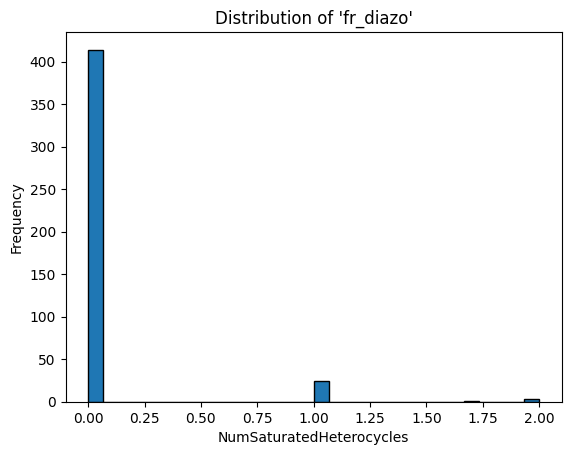

In [25]:
# Plot the histogram
plt.hist(df['NumSaturatedHeterocycles'], bins=30, edgecolor='black')
plt.title("Distribution of 'fr_diazo'")
plt.xlabel("NumSaturatedHeterocycles")
plt.ylabel("Frequency")
plt.show()

In [26]:
# Calculate percentage of each unique value
value_percentages = df['fr_diazo'].value_counts(normalize=True) * 100

# Display as a DataFrame
percentage_df = value_percentages.reset_index()
percentage_df.columns = ['Value', 'Percentage']

print(percentage_df)

KeyError: 'fr_diazo'

In [58]:
# Calculate Pearson correlation
correlation = df['fr_diazo'].corr(df['Irritation'], method='pearson')
print(f"Pearson Correlation: {correlation}")

# Calculate Spearman correlation (for non-linear relationships)
spearman_corr = df['fr_diazo'].corr(df['Irritation'], method='spearman')
print(f"Spearman Correlation: {spearman_corr}")


Pearson Correlation: -0.01902715038099475
Spearman Correlation: -0.019027150380994725


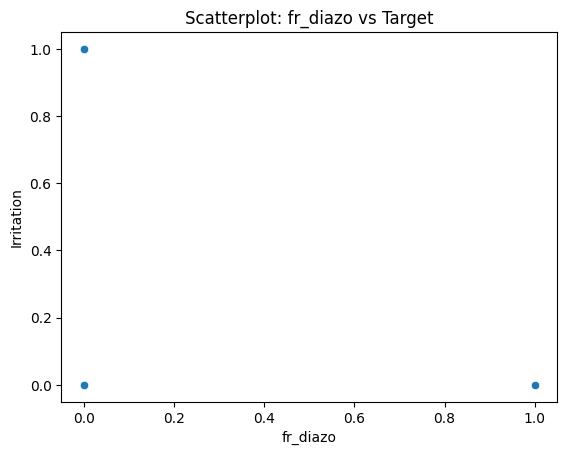

In [59]:
sns.scatterplot(x=df['fr_diazo'], y=df['Irritation'])
plt.title("Scatterplot: fr_diazo vs Target")
plt.show()

## Outliers

In [25]:
def detect_outliers(df):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_mask = (df < lower_bound) | (df > upper_bound)
    
    # Replace outliers with median
    median_values = df.median(axis=1)
    df = df.where(~outlier_mask, median_values, axis=0)


    outliers = df[outlier_mask.any(axis=1)]
    num_outliers = outliers.shape[0]
    print(f"Number of outliers detected: {num_outliers}")

    return df

In [26]:
df = detect_outliers(df)

Number of outliers detected: 439


## Scaling

In [79]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
normalized_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
df = pd.DataFrame(normalized_data, columns=df.columns)

df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,0.240357,0.240357,0.122466,0.883965,0.516715,0.146120,0.137076,0.114651,0.138183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266667,0.0
1,1.0,0.656612,0.656612,0.072275,0.843846,0.460035,0.308456,0.108934,0.097309,0.109824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1.0,0.657227,0.657227,0.106517,0.830971,0.472453,0.592431,0.117575,0.105978,0.118522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,1.0,0.250199,0.250199,0.321182,0.924882,0.525440,0.085153,0.074889,0.070777,0.074976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.478105,0.478105,0.073296,0.873840,0.602064,0.085153,0.055022,0.049756,0.055455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Class distribution

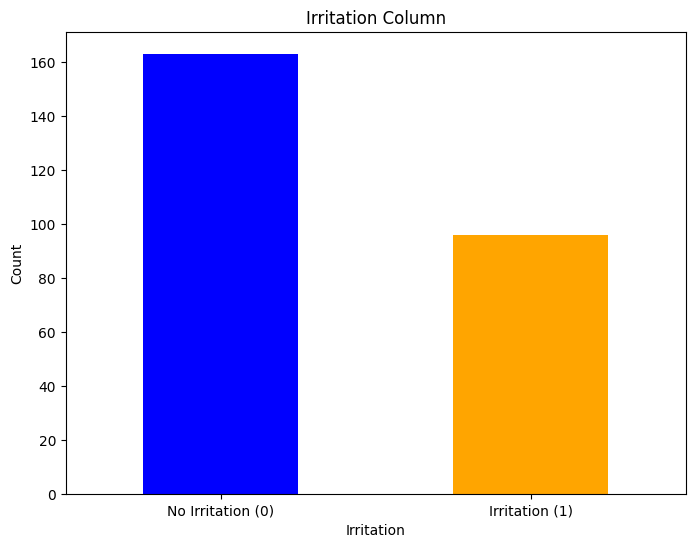

In [80]:
# Plotting class imbalance
plt.figure(figsize=(8, 6))
df['Irritation'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Irritation Column')
plt.xlabel('Irritation')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Irritation (0)', 'Irritation (1)'], rotation=0)
plt.show()

In [ ]:
df.shape

# Data download

In [81]:
import os

# Define the file name (you can customize it)
file_name = "cleaned_df_test.xlsx"

# Export the DataFrame to Excel
df.to_excel(file_name, index=False)  # index=False excludes the index column

# Optionally, you can confirm the file was saved in the current directory
print(f"File saved to: {os.path.abspath(file_name)}")


File saved to: /Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation/cleaned_df_test.xlsx
